# Imports and Seed Management

In [14]:
from setup import Env

EXPERIMENT_NAME = "exploratory-data-analysis"

env = Env(EXPERIMENT_NAME)

Environment loaded. Project path: /home/matti/Git/Kaggle-Competition-Jaguar-Re-identification


In [15]:
import os

os.environ['PYTHONHASHSEED'] = str(51)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import wandb
import pandas as pd
import fiftyone as fo
import fiftyone.brain as fob
import glob

from src.datasets import EmbeddingDataset
from src.models import (
    MegaDescriptorL384,
    ArcFaceModel
)
from src.submission import prepare_submission_file
from src.training import train_loop
from src.utils import (
    get_device,
    set_seeds,
    create_stratified_split,
    get_embeddings,
    get_train_df,
    get_identity_counts,
    create_deterministic_training_dataloader,
)
from src.visualization import (
    visualize_train_val_distribution,
    visualize_identity_distribution,
    visualize_embeddings_mds,
    visualize_nearest_neighbors,
    visualize_training_history
)
from src.wandb import (
    log_train_val_distribution,
    add_model_artifact,
    add_submission_artifact
)

# Set random seeds for reproducibility
RANDOM_SEED = 42
set_seeds(RANDOM_SEED)

print(f"PyTorch version: {torch.__version__}")

All random seeds set to 42 for reproducibility
PyTorch version: 2.9.1+cu128


Initialize wandb run.

In [ ]:
# Configuration
config = {
    # Model
    "embedding_model": MegaDescriptorL384.get_model_name(),

    # Reproducibility
    "seed": RANDOM_SEED,
}

print("Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Configuration:
  seed: 42


In [17]:
# Initialize Weights and Biases for experiment tracking
# Key hyperparameters are tracked explicitly for easy filtering in W&B dashboard
wandb.login(key=env.WANDB_API_KEY)

wandb.init(
    project=env.WANDB_PROJECT,
    config=config,
    name=EXPERIMENT_NAME,
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


# Dataset Creation

The existing dataset is removed if it already exists. Please be aware that any additional changes will be lost if the notebook is rerun.

In [18]:
dataset_name = "jaguar-reid-dataset"

# Remove existing dataset if it exists
if dataset_name in fo.list_datasets():
    fo.delete_dataset(dataset_name)

dataset = fo.Dataset(dataset_name)

Load all training images from the train path while using the CSV for the ground thruth label.

In [19]:
train_csv_path = env.DATA_PATH / "train.csv"
train_image_folder_path = env.DATA_PATH / "train"

train_data = pd.read_csv(train_csv_path)
    
train_samples = []
for idx, row in train_data.iterrows():
    img_path = train_image_folder_path / row['filename']
    ground_truth = row['ground_truth']
    
    sample = fo.Sample(
        name=row['filename'],
        filepath=str(img_path),
        ground_truth=fo.Classification(label=ground_truth),
        tags=["train"]
    )
    train_samples.append(sample)

dataset.add_samples(train_samples)
dataset.save()

 100% |███████████████| 1895/1895 [350.0ms elapsed, 0s remaining, 5.4K samples/s]      


Load the test data from the test image folder without CSV.

In [20]:
test_image_folder_path = env.DATA_PATH / "test"
test_image_paths = glob.glob(str(test_image_folder_path / "*.png"))

test_samples = []
for img_path in test_image_paths:
    sample = fo.Sample(
        name=img_path.split("/")[-1],
        filepath=img_path,
        ground_truth=fo.Classification(label="unknown"),
        tags=["test"]
    )
    test_samples.append(sample)

dataset.add_samples(test_samples)
dataset.save()

 100% |█████████████████| 371/371 [116.0ms elapsed, 0s remaining, 3.2K samples/s]     


In [21]:
dataset.compute_metadata()

Computing metadata...


 100% |███████████████| 2266/2266 [2.3s elapsed, 0s remaining, 984.9 samples/s]        


In [22]:
tag_counts = dataset.count_sample_tags()
print(f"Tag counts after split: {tag_counts}")

Tag counts after split: {'train': 1895, 'test': 371}


Class distribution visualization for the training and validation splits.

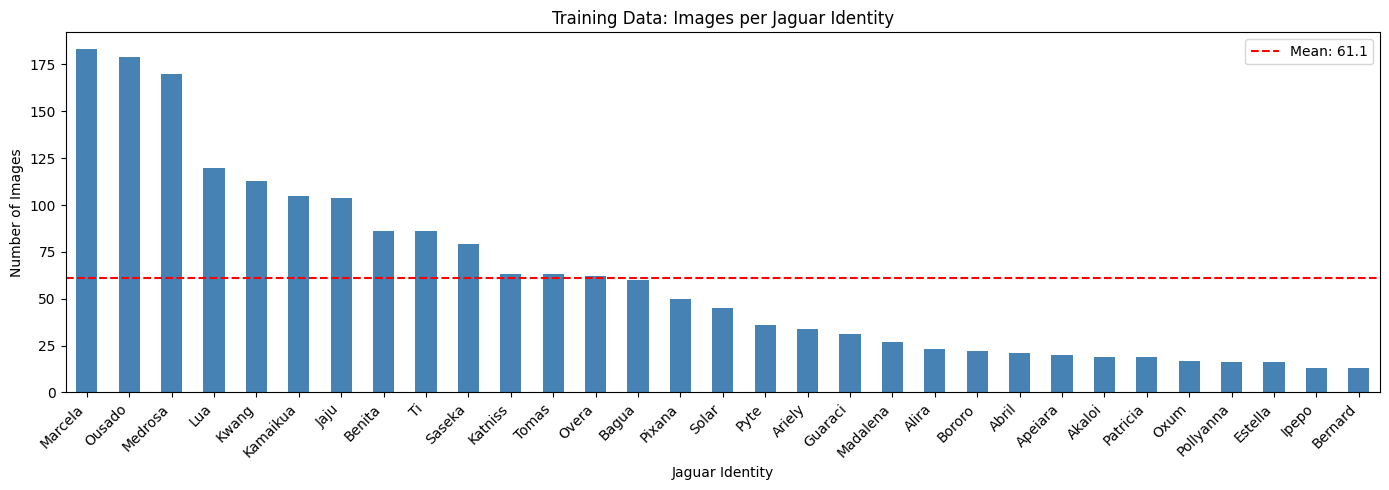

In [23]:
train_view = dataset.match_tags("train")
train_identity_counts = train_view.count_values("ground_truth.label")
train_identity_counts_df = pd.Series(train_identity_counts).sort_values(ascending=False)

num_classes = len(train_identity_counts_df)

fig = visualize_identity_distribution(train_identity_counts_df)

# Embedding Analysis

In [24]:
device = get_device()
print(f"Using device: {device}")

Using CPU
Using device: cpu


In [25]:
megadescriptor = MegaDescriptorL384()
megadescriptor.to(device)
megadescriptor.print_model_summary()

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

Model loaded successfully
  Parameters: 195,198,516
  Embedding dimension: 1536


In [ ]:
model = ArcFaceModel(
    input_dim=megadescriptor.get_embedding_size(),
    num_classes=num_classes,
    embedding_dim=config["embedding_dim"],
    hidden_dim=config["hidden_dim"],
    margin=config["arcface_margin"],
    dropout=config["dropout"],
).to(device)
model.print_model_summary()


In [ ]:
checkpoint_path = env.PROJECT_PATH / "checkpoints" / "megadescriptor-arcface-local" / "best_model.pth"
add_model_artifact(checkpoint_path)

checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

In [ ]:
combined_model = nn.Sequential(
    megadescriptor,
    model
).to(device)
combined_model.eval()

In [ ]:
image_paths = [sample.filepath for sample in dataset]
cache_path = env.EMBEDDINGS_PATH / "embeddings.pt"

embeddings = get_embeddings(
    model=combined_model,
    image_paths=image_paths,
    batch_size=config["batch_size"],
    cache_path=cache_path,
    device=device,
)

In [ ]:
labels = [sample['ground_truth.label'] for sample in dataset]

fig_finetuned = visualize_embeddings_mds(
    embeddings,
    labels,
    "Fine-tuned ArcFace Embeddings (After Training)",
    config["seed"],
    log_name="finetuned_embeddings_mds"
)

In [ ]:
for sample, embedding in zip(dataset, embeddings):
    sample["embedding"] = fo.Embedding(embedding.cpu().numpy())
dataset.save()

In [ ]:
similarity_index = fob.compute_similarity(
    dataset,
    embeddings="embedding",
    brain_key="cosine_similarity_index",
    backend="sklearn",
    metric="cosine"
)

In [ ]:
pca_visualization = fob.compute_visualization(
    dataset,
    method="pca",
    embeddings="embeddings",
    num_dims=2,
    brain_key="pca_visualization_embeddings"
)

plot = pca_visualization.visualize(labels="ground_truth", axis_equal=True)
plot.save(env.CHECKPOINT_PATH / "embeddings_pca.png", height=400, width=800)
wandb.log({"pca_visualization": wandb.Image(plot)})

umap_visualization = fob.compute_visualization(
    dataset,
    method="umap",
    embeddings="embeddings",
    num_dims=2,
    brain_key="umap_visualization_embeddings"
)
plot = umap_visualization.visualize(labels="ground_truth", axis_equal=True)
plot.save(env.CHECKPOINT_PATH / "embeddings_umap.png", height=400, width=800)
wandb.log({"umap_visualization": wandb.Image(plot)})

In [ ]:
fob.compute_uniqueness(
    dataset,
    embeddings="embeddings"
)

fob.compute_representativeness(
    dataset,
    embeddings="embeddings"
)

# Session

Launch app for visual inspection.

In [13]:
session = fo.launch_app(dataset, auto=False)
session.open_tab()

Session launched. Run `session.show()` to open the App in a cell output.


<IPython.core.display.Javascript object>

# Export

Export the created dataset in FiftyOne format. We do not export the files to save memory.

In [12]:
export_dir = env.DATA_PATH / dataset_name
export_dir.mkdir(parents=True, exist_ok=True)

print(f"Exporting dataset '{dataset_name}' to: {export_dir}")

dataset.export(
    export_dir=str(export_dir),
    dataset_type=fo.types.FiftyOneDataset,  # preserves groups, modalities, metadata, labels, etc.
    overwrite=True,
    progress=True,
    export_media=False,
)

print("Export finished.")

Exporting dataset 'jaguar-reid-dataset' to: /home/matti/Git/finding-tomas/data/jaguar-reid-dataset
Exporting samples...
 100% |██████████████████| 2266/2266 [102.5ms elapsed, 0s remaining, 22.1K docs/s]    
Export finished.
